Set Up

In [64]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import seaborn as sns
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import utils
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import ZeroPadding2D, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model, load_model

%matplotlib notebook
import numpy as np
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

Split Dataset

In [6]:
%pip install split-folders
import splitfolders

%cd C:\Users\szeyu\Documents\GitHub\CNHack_2023
%pwd

splitfolders.ratio('Alzheimer_MRI_Dataset', output="dataset", seed=1337, ratio=(.8,0.1,0.1)) 


c:\Users\szeyu\Documents\GitHub\CNHack_2023


Prep dataset

In [7]:
X_train = []
X_val   = []
X_test  = []

Y_train = []
Y_val   = []
Y_test  = []

tmp_x_train = []
tmp_x_val   = []
tmp_x_test  = []

tmp_y_train = []
tmp_y_val   = []
tmp_y_test  = []

imageCatMap = {
    "Mild_Demented": 0,
    "Moderate_Demented" : 1,
    "Non_Demented" : 2,
    "Very_Mild_Demented" : 3
}

for cat in imageCatMap.keys():
    for imgName in os.listdir(r"dataset\train\{}".format(cat)):
        image = Image.open(r"dataset\train\{}\{}".format(cat, imgName))
        npArr = np.asarray(image,dtype="float16")
        npArr = np.divide(npArr,255)
        tmp_x_train.append(npArr)
        tmp_y_train.append(imageCatMap[cat])
        
    for imgName in os.listdir(r"dataset\val\{}".format(cat)):
        image = Image.open(r"dataset\val\{}\{}".format(cat, imgName))
        npArr = np.asarray(image,dtype="float16")
        npArr = np.divide(npArr,255)
        tmp_x_val.append(npArr)
        tmp_y_val.append(imageCatMap[cat])

    for imgName in os.listdir(r"dataset\test\{}".format(cat)):
        image = Image.open(r"dataset\test\{}\{}".format(cat, imgName))
        npArr = np.asarray(image,dtype="float16")
        npArr = np.divide(npArr,255)
        tmp_x_test.append(npArr)
        tmp_y_test.append(imageCatMap[cat])



X_train = np.array(tmp_x_train)
X_val   = np.array(tmp_x_val)
X_test  = np.array(tmp_x_test)

Y_train = np.array(tmp_y_train)
Y_val   = np.array(tmp_y_val)
Y_test  = np.array(tmp_y_test)

print('Train: X=%s, Y=%s' % (X_train.shape, Y_train.shape))
print('Val:   X=%s, Y=%s' % (X_val.shape,   Y_val.shape))
print('Test:  X=%s, Y=%s' % (X_test.shape,  Y_test.shape))


Y_train_org = Y_train
Y_test_org  = Y_test
Y_val_org   = Y_val
#Prev: just test and train: 5119 train - 1281 test

Train: X=(5119, 128, 128), Y=(5119,)
Val:   X=(639, 128, 128), Y=(639,)
Test:  X=(642, 128, 128), Y=(642,)


Check Images

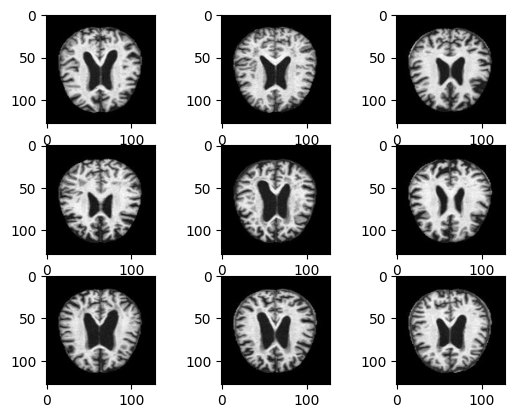

In [8]:
# plot first 9 images of the training dataset
for i in range(9):

    img_float64 = X_train[i].astype("float64")

    # define subplot
    plt.subplot(331 + i)
    # plot raw pixel data
    plt.imshow(img_float64, cmap=plt.get_cmap('gray'))
    
# show the figure
plt.show()

Categorize Data

In [9]:
Y_train = utils.to_categorical(Y_train_org, 4)
Y_val   = utils.to_categorical(Y_val_org, 4)
Y_test  = utils.to_categorical(Y_test_org, 4)

In [10]:
# # 128 * 128 = 16384
# X_train = X_train.reshape(X_train.shape[0], 16384)
# X_val   = X_val.reshape(X_val.shape[0], 16384)
# X_test  = X_test.reshape(X_test.shape[0], 16384)
               
# print("Number of training examples: ", X_train.shape[0],
#      "and the image is of the shape (%d)"%(X_train.shape[1]))
# print("Number of validating examples: ", X_val.shape[0],
#      "and the image is of the shape (%d)"%(X_val.shape[1]))
# print("Number of testing examples: ", X_test.shape[0],
#      "and the image is of the shape (%d)"%(X_test.shape[1]))

# print(X_test.shape)

In [57]:
model = Sequential(name="Sequential_CNN")

model.add(Conv2D(4, kernel_size=(3, 3),
                 padding="same",
                 activation="relu", input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2),
                       padding="valid"))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

#=====================================
savedModel = Sequential(name="Sequential_CNN_saved")

savedModel.add(Conv2D(4, kernel_size=(3, 3),
                 padding="same",
                 activation="relu", input_shape=(128, 128, 1)))
savedModel.add(MaxPooling2D(pool_size=(2, 2),
                       padding="valid"))

savedModel.add(Flatten())

savedModel.add(Dense(64, activation='relu'))
savedModel.add(Dense(4, activation='softmax'))

savedModel.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 4)       40        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 4)        0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 16384)             0         
                                                                 
 dense_12 (Dense)            (None, 64)                1048640   
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 1,048,940
Trainable params: 1,048,940
Non-trainable params: 0
__________________________________________

In [18]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
             metrics=['accuracy'])
savedModel.compile(optimizer='sgd', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [19]:
epochs     = 10
batch_size = 32
training = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_val,Y_val))

Epoch 1/10
160/160 [==============================] - 17s 93ms/step - loss: 1.0197 - accuracy: 0.5007 - val_loss: 1.0251 - val_accuracy: 0.5008
Epoch 2/10
160/160 [==============================] - 14s 85ms/step - loss: 0.9649 - accuracy: 0.5343 - val_loss: 0.9733 - val_accuracy: 0.5086
Epoch 3/10
160/160 [==============================] - 12s 75ms/step - loss: 0.9365 - accuracy: 0.5474 - val_loss: 0.9003 - val_accuracy: 0.5556
Epoch 4/10
160/160 [==============================] - 16s 100ms/step - loss: 0.9033 - accuracy: 0.5724 - val_loss: 0.8797 - val_accuracy: 0.5712
Epoch 5/10
160/160 [==============================] - 12s 77ms/step - loss: 0.8747 - accuracy: 0.5823 - val_loss: 0.9104 - val_accuracy: 0.5430
Epoch 6/10
160/160 [==============================] - 11s 69ms/step - loss: 0.8599 - accuracy: 0.6011 - val_loss: 0.8282 - val_accuracy: 0.6072
Epoch 7/10
160/160 [==============================] - 14s 88ms/step - loss: 0.8298 - accuracy: 0.6132 - val_loss: 0.8106 - val_accuracy

In [20]:
performance = model.evaluate(X_test, Y_test, verbose=0)

print("test score", performance[0]) 
print("test accuracy", performance[1])

test score 0.7577612400054932
test accuracy 0.6978192925453186


21/21 [==============================] - 1s 37ms/step


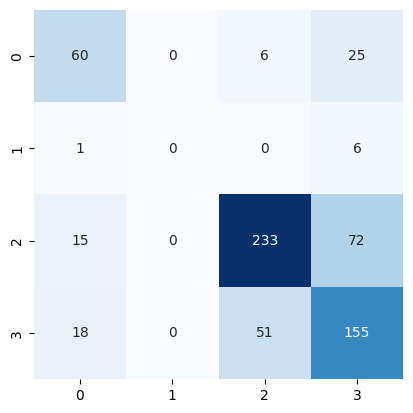

In [34]:
Y_pred   = model.predict(X_test)
Y_pred_c = np.argmax(Y_pred, axis=1)
Y_test_c = np.argmax(Y_test, axis=1)
matrix_confusion = confusion_matrix(Y_test_c, Y_pred_c)

sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False )
plt.show()

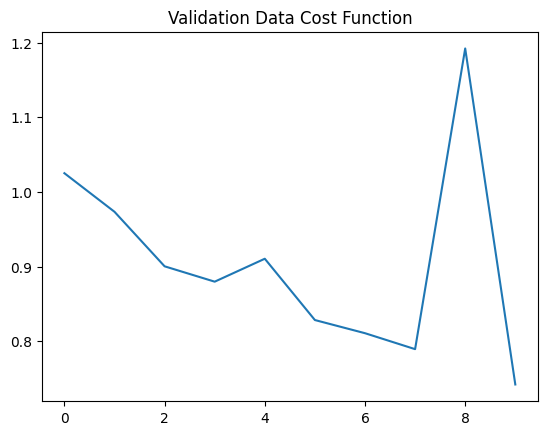

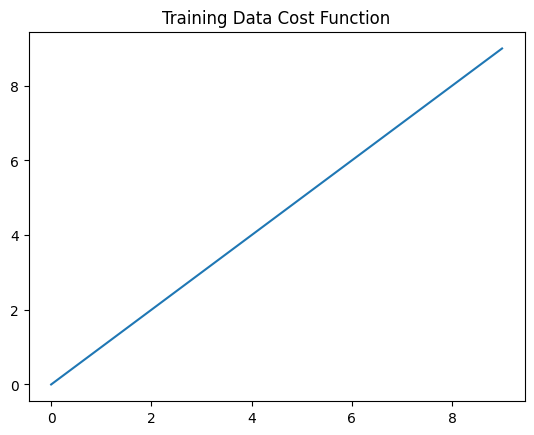

In [22]:
epoch_count = list(range(epochs))
#Tesing Data = Vaildation Data, lower is better
val_loss = training.history['val_loss']
#Training Data, lower is better
loss = training.history['loss']

plt.plot( epoch_count, val_loss )
plt.title('Validation Data Cost Function')
plt.show()
plt.plot( epoch_count,   )
plt.title('Training Data Cost Function')
plt.show()

In [68]:
# saving and loading the .h5 model
 
# save model
model.save('CNN_Alzheimer_Prediction')
print('Model Saved!')
 
# load model
savedModel = load_model('CNN_Alzheimer_Prediction')
print('Model Loaded!')

image = Image.open(r"dataset\test\Mild_Demented\mild_2.jpg")
npArr = np.asarray(image,dtype="float16")
npArr = np.divide(npArr,255)
data  = np.array([npArr])


ans_org = model.predict(data)
print(ans_org)

ans = savedModel.predict(data)
print(ans)

INFO:tensorflow:Assets written to: CNN_Alzheimer_Prediction\assets


INFO:tensorflow:Assets written to: CNN_Alzheimer_Prediction\assets


Model Saved!


Model Loaded!
1/1 [==============================] - 0s 225ms/step
[[0.18106328 0.22777903 0.27092803 0.32022968]]


1/1 [==============================] - 0s 189ms/step
[[0.18106328 0.22777903 0.27092803 0.32022968]]
